In [1]:
import requests
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Get and read in data

In [65]:
%run zillow_data_scrape.py

Enter the city name:  west fargo
Enter the state in abbreviation format (eg: Minnesota = MN) :  nd


Scraping data...
Done.
West-fargo_Homes_ForSale.csv is available for viewing.
West-fargo_Apartments_ForRental.csv is available for viewing.


In [3]:
df = pd.read_csv("Fargo_Homes_ForSale.csv")
df2 = pd.read_csv("Fargo_Apartments_ForRental.csv")

null_price = df[df["unformattedPrice"].isnull()]
null_price2 = df[df["unformattedPrice"].isnull()]
df.drop(null_price.index, inplace=True)
df2.drop(null_price2.index, inplace=True)

#set zestimate equal to price if 0, set best_deal equal to division
df.loc[(df['zestimate'].isnull()) | (df['zestimate'] == 0), 'zestimate'] = df['unformattedPrice']
df['best_deal'] = df['zestimate'] - df['unformattedPrice']
df.sort_values("best_deal")

df2.loc[(df2['zestimate'].isnull()) | (df2['zestimate'] == 0), 'zestimate'] = df2['unformattedPrice']
df2['best_deal'] = df2['zestimate'] - df2['unformattedPrice']
df2.sort_values("unformattedPrice")
df

,Unnamed: 0,zpid,imgSrc,statusType,price,unformattedPrice,zestimate,best_deal,address,addressZipcode,beds,baths,area,variableData,hasOpenHouse,brokerName,builderName
0,131,2108963637,https://photos.zillowstatic.com/fp/7e2268d630a...,FOR_SALE,"$110,000",110000,237900,127900,"1840 15th Ave S, Fargo, ND 58103",58103,3.0,2.0,1626.0,"{'type': 'DAYS_ON', 'text': '263 days on Zillow'}",NaN,"Park Co., REALTORS(r)",NaN
1,56,98773916,https://photos.zillowstatic.com/fp/ad0bb78ddad...,FOR_SALE,"$249,900",249900,254153,4253,"4709 Harvest Dr S, Fargo, ND 58104",58104,3.0,2.0,2086.0,"{'type': 'DAYS_ON', 'text': '10 days on Zillow'}",NaN,eXp Realty (219 WF),NaN
2,111,123901535,https://photos.zillowstatic.com/fp/f96bd0383bd...,FOR_SALE,"$247,000",247000,251204,4204,"4328 39 1/2 Ave S, Fargo, ND 58104",58104,3.0,2.0,1968.0,"{'type': 'DAYS_ON', 'text': '15 days on Zillow'}",NaN,Krabbenhoft Real Estate Team,NaN
3,343,66548642,https://photos.zillowstatic.com/fp/07bb57497ed...,FOR_SALE,"$240,000",240000,244085,4085,"5036 9th Ave S, Fargo, ND 58103",58103,4.0,2.0,1788.0,"{'type': 'DAYS_ON', 'text': '10 days on Zillow'}",NaN,REAL,NaN
4,330,123900036,https://photos.zillowstatic.com/fp/186cf51b593...,FOR_SALE,"$237,500",237500,241542,4042,"3311 Jefferson St S, Fargo, ND 58104",58104,3.0,2.0,1686.0,"{'type': 'DAYS_ON', 'text': '2 days on Zillow'}",NaN,RE/MAX Legacy Realty,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,288,2065637577,https://photos.zillowstatic.com/fp/3195f57f3af...,FOR_SALE,"$1,287,744",1287744,1287744,0,"505 Oak St N #13, Fargo, ND 58102",58102,2.0,2.0,1945.0,"{'type': 'DAYS_ON', 'text': '410 days on Zillow'}",NaN,RE/MAX Legacy Realty,Enclave
322,308,2065637571,https://photos.zillowstatic.com/fp/3195f57f3af...,FOR_SALE,"$1,311,702",1311702,1311702,0,"505 Oak St N #14, Fargo, ND 58102",58102,2.0,2.0,1559.0,"{'type': 'DAYS_ON', 'text': '410 days on Zillow'}",NaN,RE/MAX Legacy Realty,Enclave
323,291,2060425750,https://photos.zillowstatic.com/fp/351586a4a81...,FOR_SALE,"$1,332,000",1332000,1332000,0,"300 Main Ave #706, Fargo, ND 58103",58103,3.0,3.0,2663.0,"{'type': 'DAYS_ON', 'text': '131 days on Zillow'}",NaN,Trilogy Real Estate,NaN
324,282,2065637647,https://photos.zillowstatic.com/fp/3195f57f3af...,FOR_SALE,"$1,336,992",1336992,1336992,0,"505 Oak St N #8, Fargo, ND 58102",58102,2.0,2.0,2001.0,"{'type': 'DAYS_ON', 'text': '410 days on Zillow'}",NaN,RE/MAX Legacy Realty,Enclave


## Homes

#### averages of price and best deal

In [50]:
home_averages = df.copy()

# Step 1: Select columns of number home_averages type
num_cols = home_averages.select_dtypes(include=['int', 'float']).drop(['zpid', 'addressZipcode'], axis=1)

# Step 2: Calculate mean of each column
mean_row = num_cols.mean()

# Step 3: Append new row to home_averagesframe
home_averages = home_averages.append(mean_row, ignore_index=True)

home_averages = home_averages.round(decimals = 2)

home_averages = home_averages[['unformattedPrice', 'zestimate', 'best_deal', 'beds', 'baths', 'area']]

print('Average House: ')
home_averages.tail(1)

Average House: 


,unformattedPrice,zestimate,best_deal,beds,baths,area
326,423060.09,420460.62,-2599.47,3.32,2.57,2342.39


In [5]:
## beds, baths, and area

In [6]:
## Histogram of prices

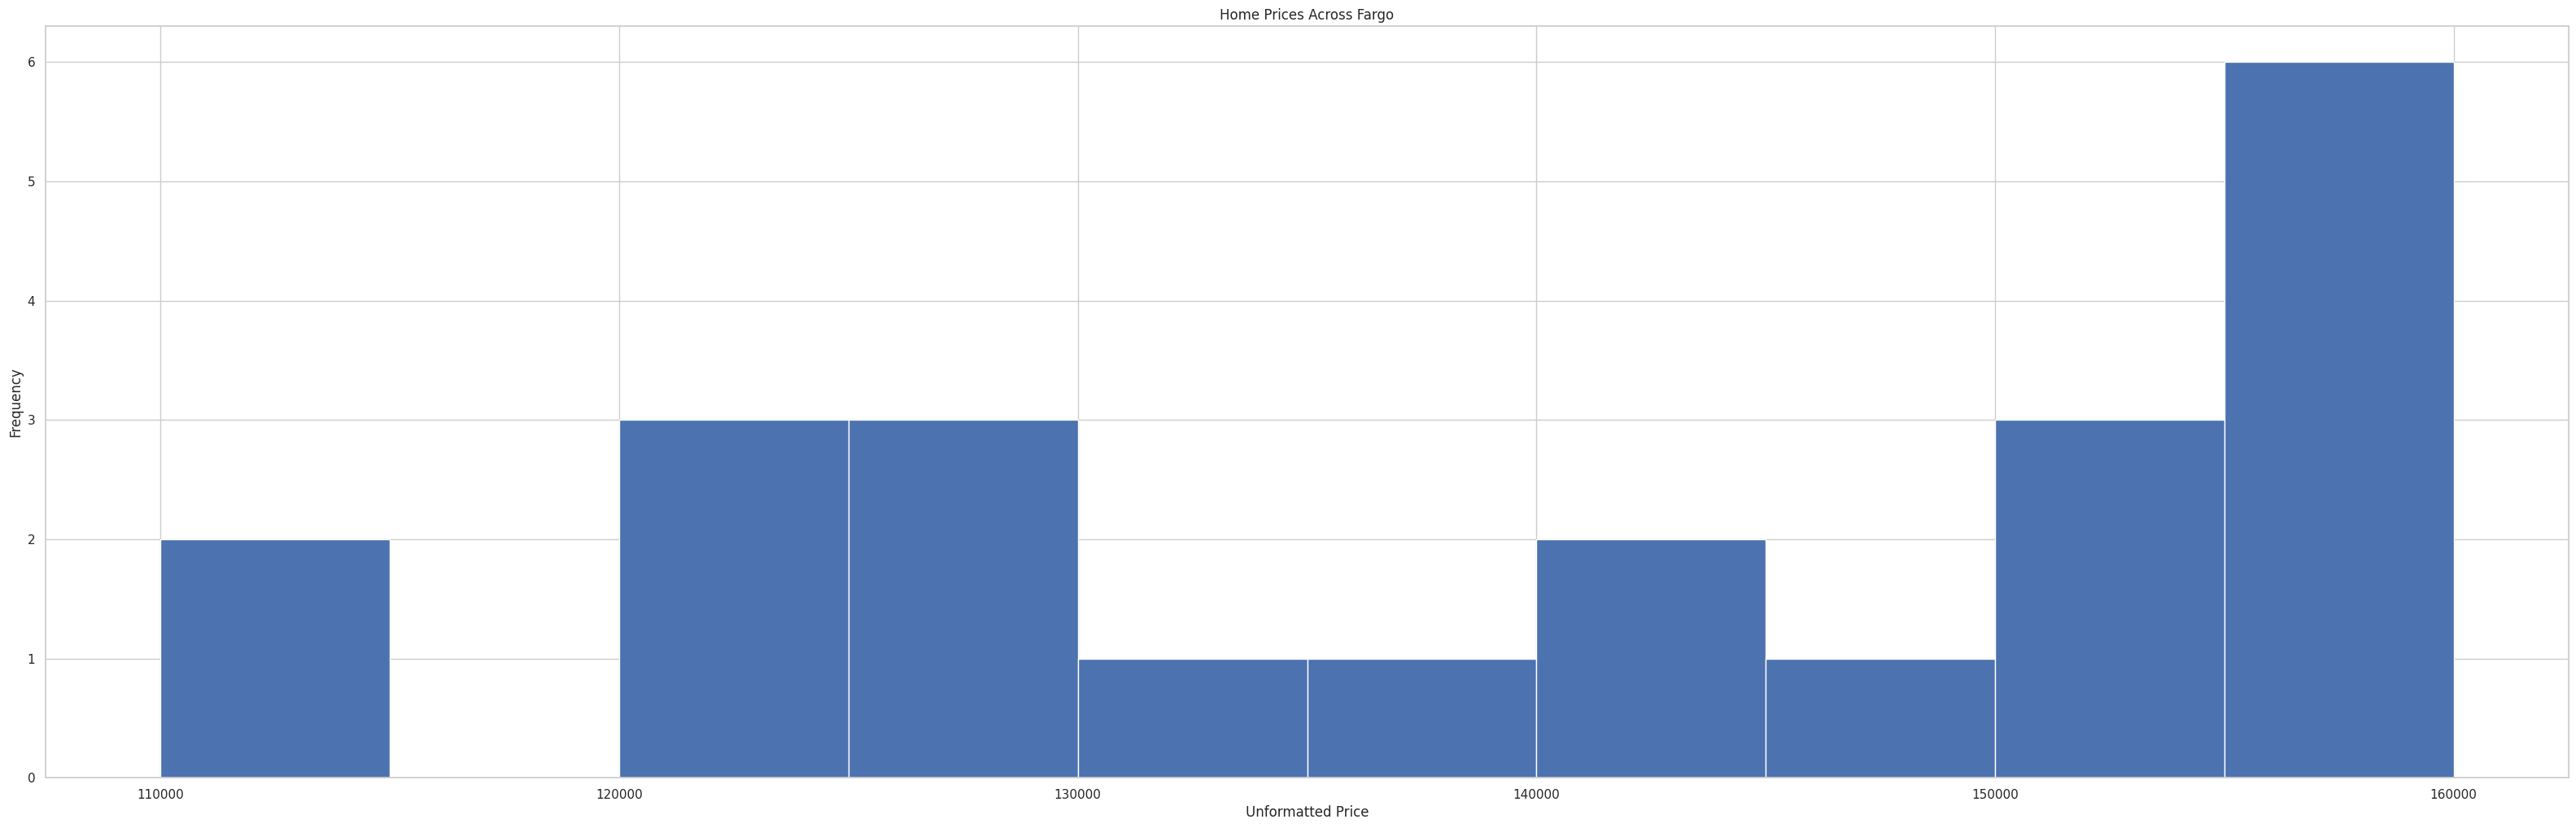

In [46]:
plt.hist(df['unformattedPrice'], bins=10, range=(110000, 160000))
plt.xlabel('Unformatted Price')
plt.ylabel('Frequency')
plt.title('Home Prices Across Fargo')
plt.show()

#### Pie chart of builders

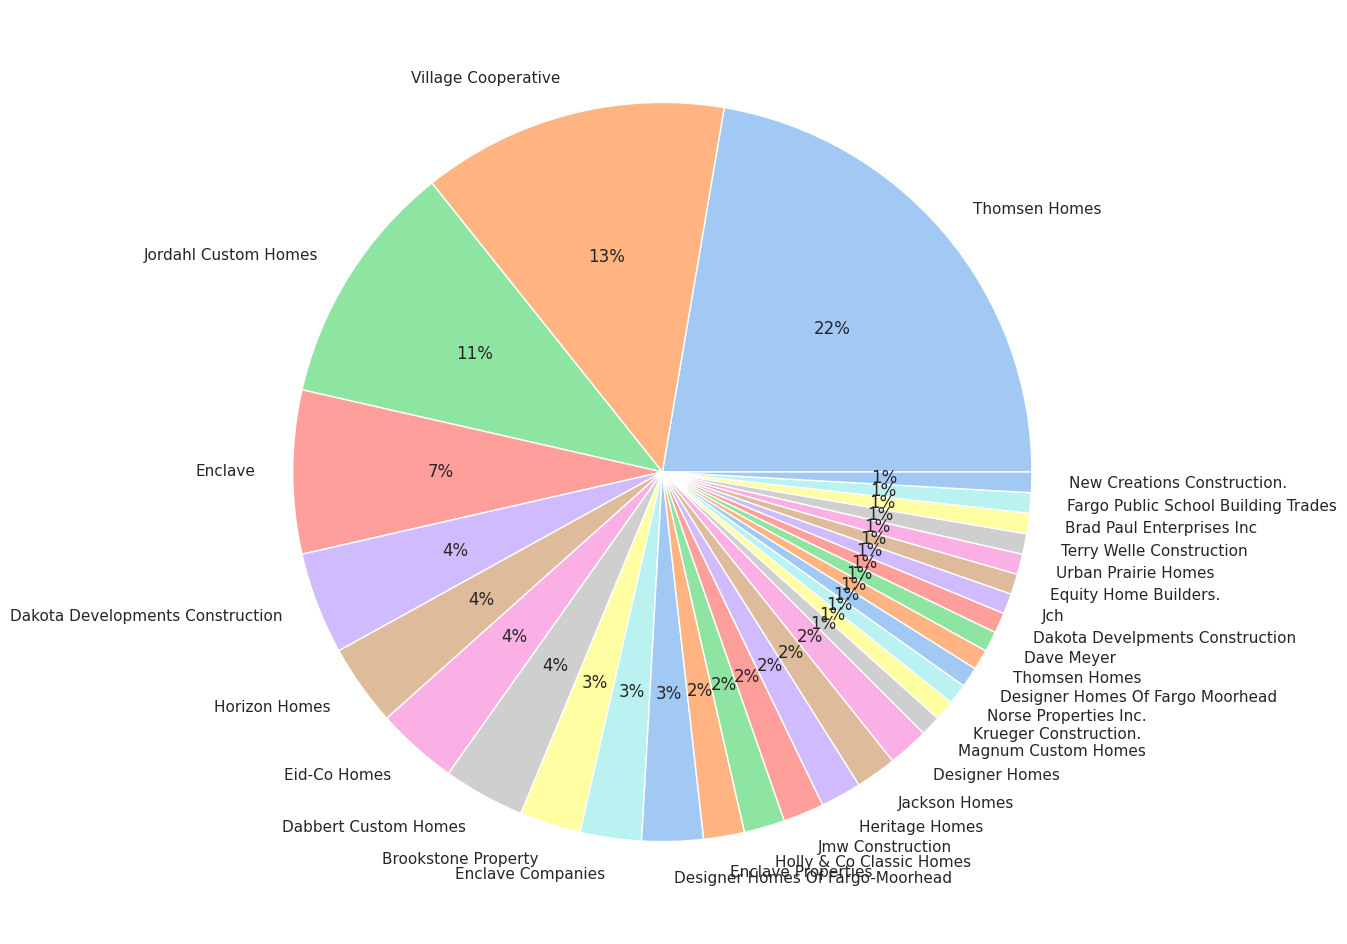

In [8]:
builders = df.copy()

#builders["builderName"].fillna("Not Listed", inplace=True)
builders['builderName'] = builders['builderName'].str.replace(', llc', '', case=False)
builders['builderName'] = builders['builderName'].str.replace('llc', '', case=False)
builders['builderName'] = builders['builderName'].str.replace(', inc', '', case=False)

# create pandas series of counts of unique values in "builderName" column
builder_counts = builders['builderName'].value_counts()

# extract values and index of pandas series
data = builder_counts.values
labels = builder_counts.index

# define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:len(data)]

sns.set(rc={"figure.figsize":(40, 12)})
# create pie chart
plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

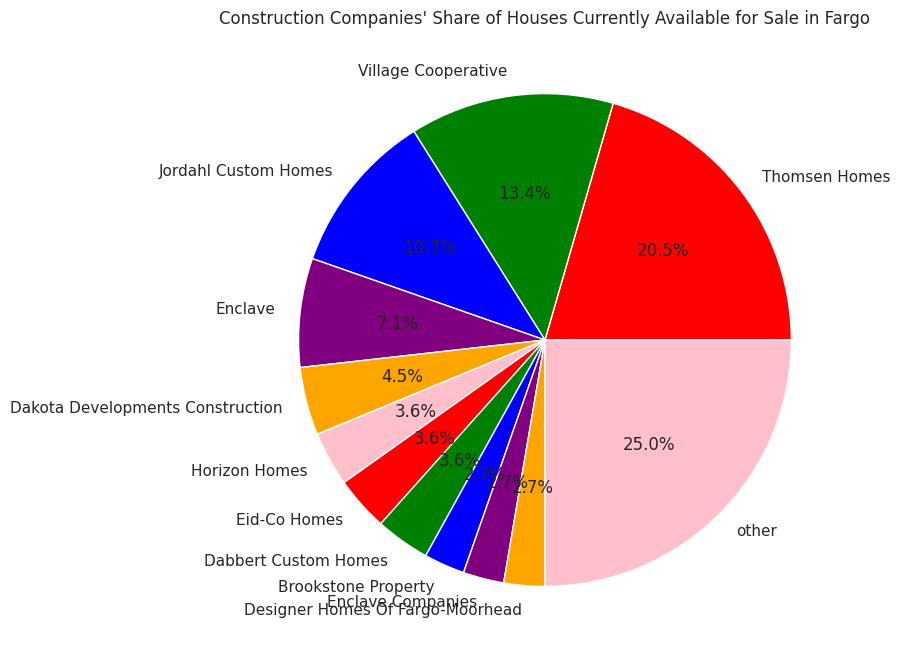

In [45]:
builder_count = df["builderName"].value_counts()

total = builder_count.sum()
threshold = total * 0.02

other_count = builder_count[builder_count < threshold].sum()
builder_count = builder_count[builder_count >= threshold]
builder_count["other"] = other_count

builder_count.plot.pie(figsize=(8, 8), autopct='%1.1f%%', colors=['red', 'green', 'blue', 'purple', 'orange', 'pink'])
plt.title("Construction Companies' Share of Houses Currently Available for Sale in Fargo")
plt.ylabel("")
plt.show()

In [9]:
## Pie chart of brokers

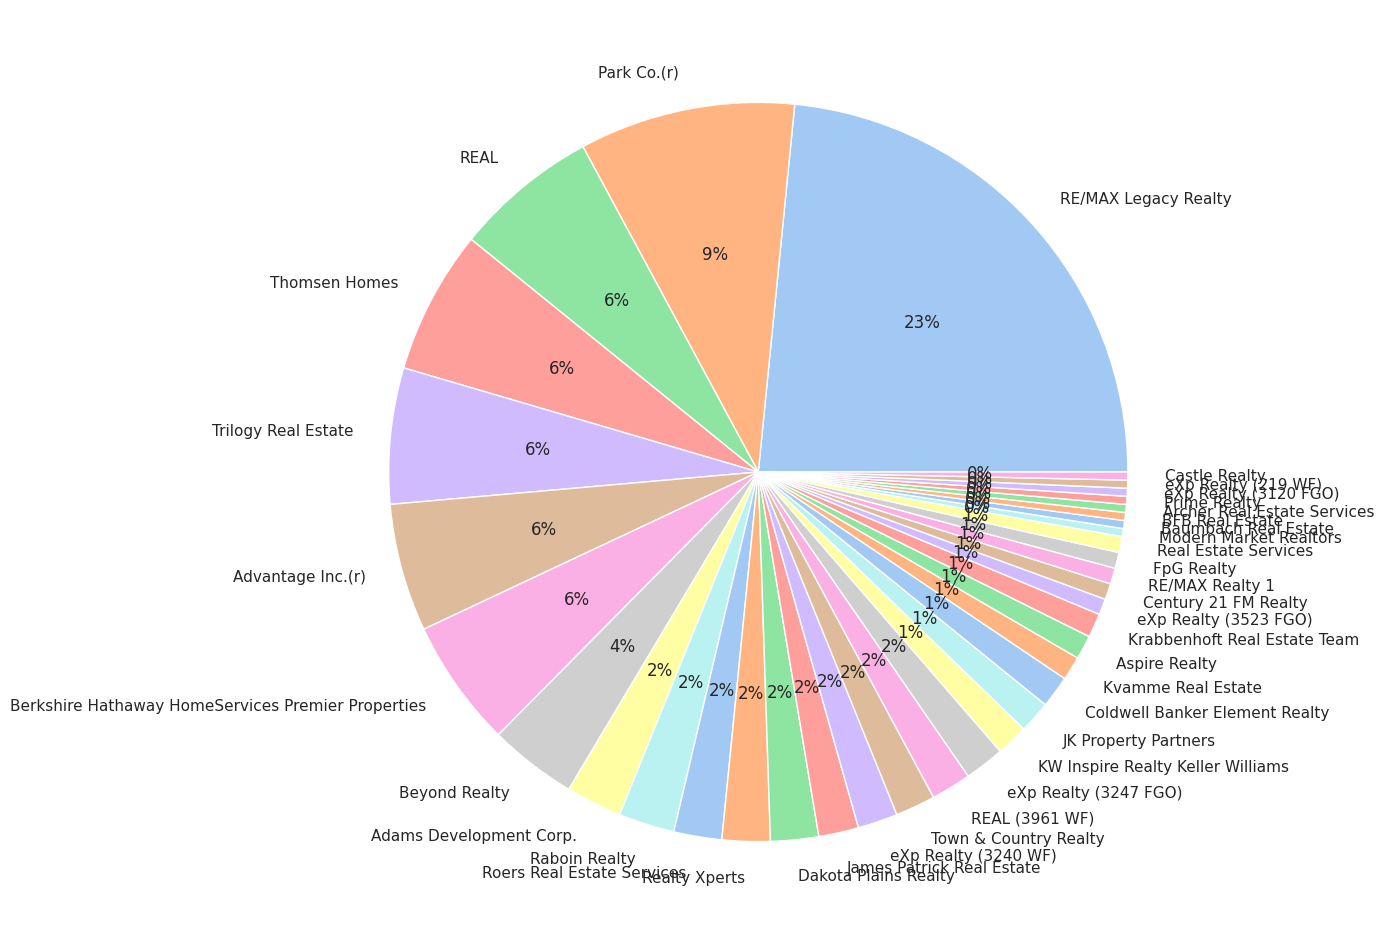

In [10]:
brokers = df.copy()
#brokers["brokerName"].fillna("Not Listed", inplace=True)
brokers['brokerName'] = brokers['brokerName'].str.replace(', llc', '', case=False)
brokers['brokerName'] = brokers['brokerName'].str.replace('llc', '', case=False)
brokers['brokerName'] = brokers['brokerName'].str.replace(', inc', '', case=False)
brokers['brokerName'] = brokers['brokerName'].str.replace(', REALTORS', '', case=False)

# create pandas series of counts of unique values in "brokerName" column
broker_counts = brokers['brokerName'].value_counts()

# extract values and index of pandas series
data = broker_counts.values
labels = broker_counts.index

# define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:len(data)]

sns.set(rc={"figure.figsize":(40, 12)})\

# create pie chart
plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

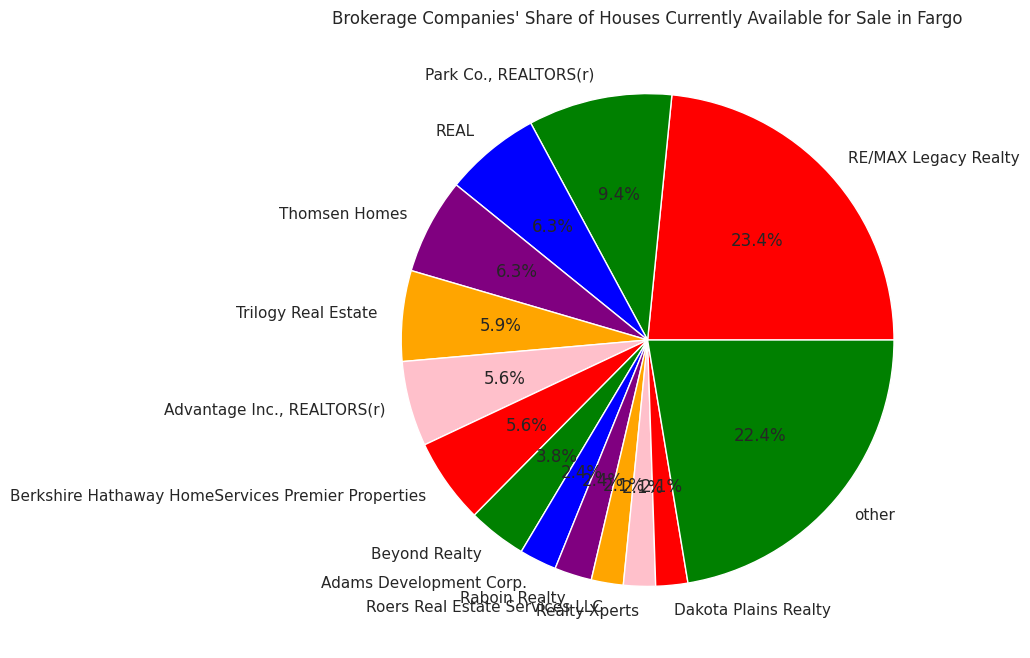

In [44]:
broker_count = df["brokerName"].value_counts()

total = broker_count.sum()
threshold = total * 0.02

other_count = broker_count[broker_count < threshold].sum()
broker_count = broker_count[broker_count >= threshold]
broker_count["other"] = other_count

broker_count.plot.pie(figsize=(8, 8), autopct='%1.1f%%', colors=['red', 'green', 'blue', 'purple', 'orange', 'pink'])
plt.title("Brokerage Companies' Share of Houses Currently Available for Sale in Fargo")
plt.ylabel("")
plt.show()

In [69]:
## Beds and Baths

TypeError: '<=' not supported between instances of 'int' and 'NoneType'

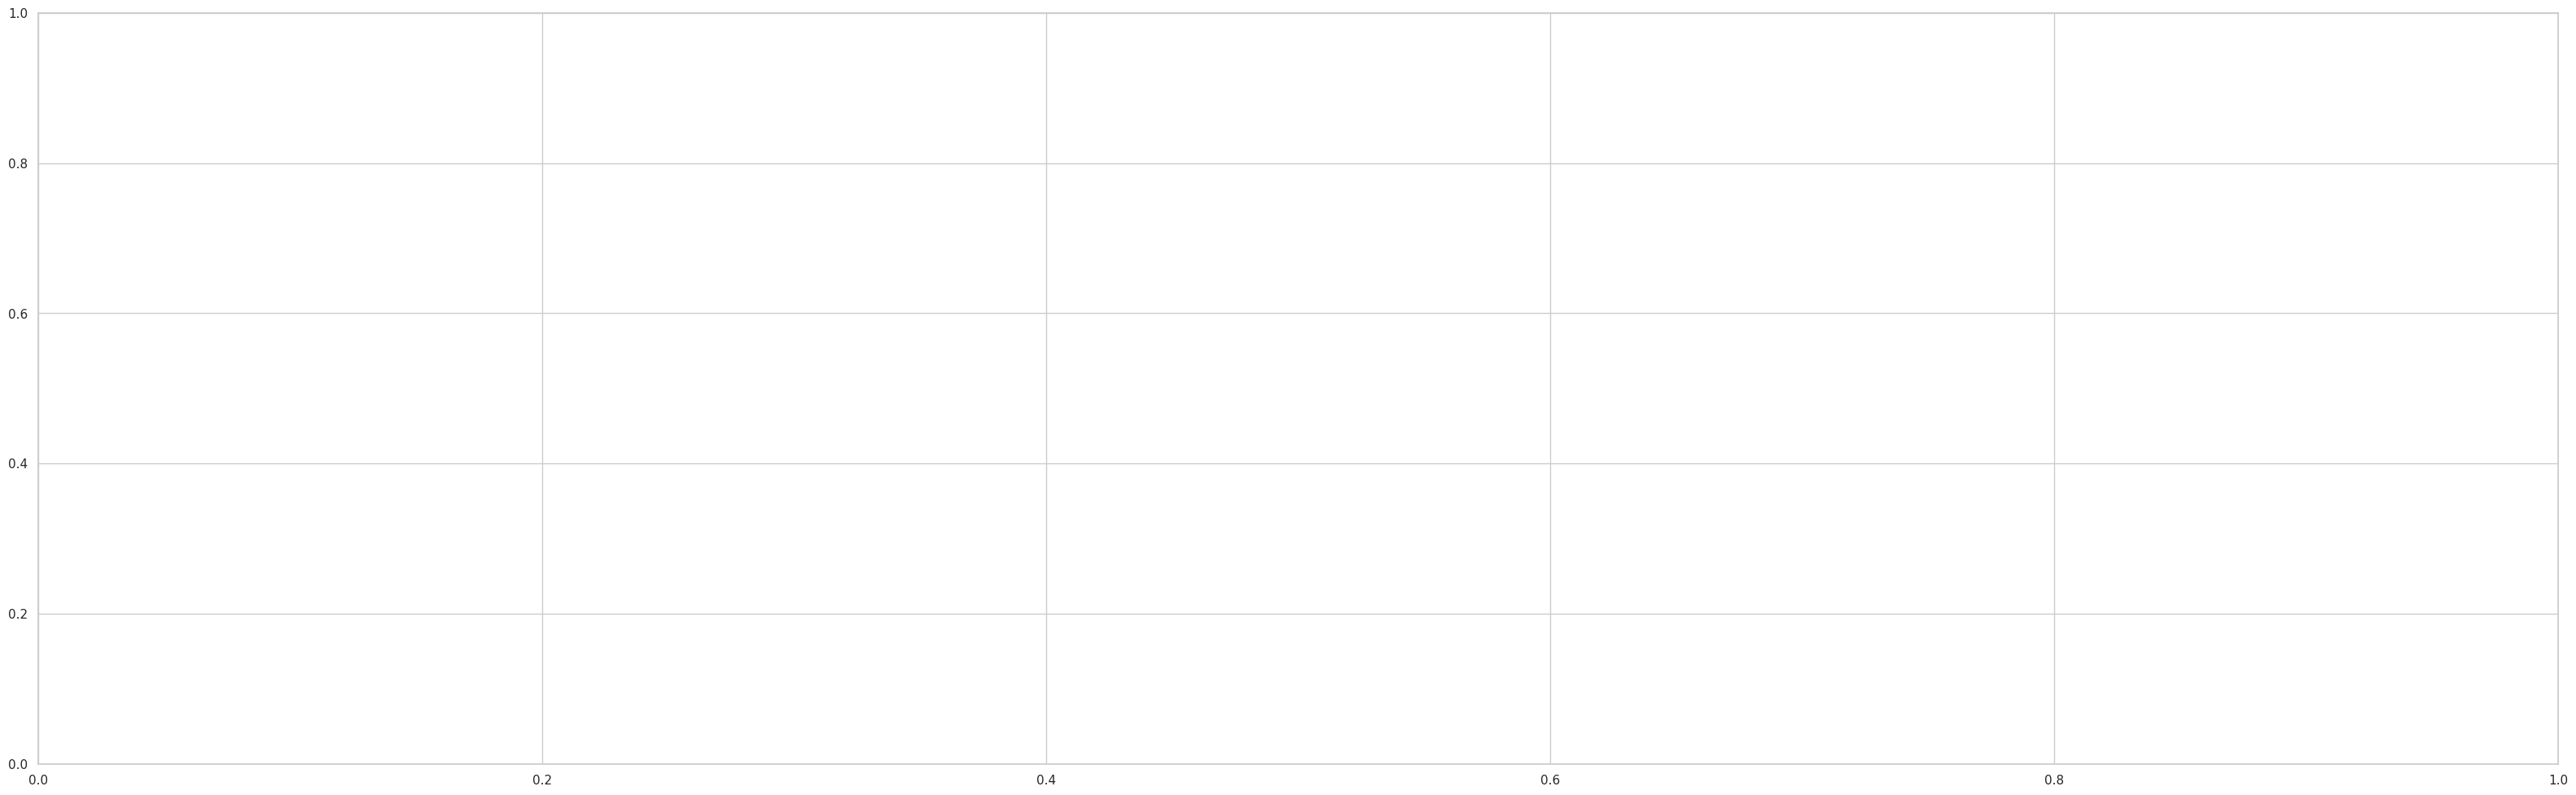

In [76]:
plt.hist(df['beds'], bins=6)
plt.xlabel('Beds')
plt.ylabel('Frequency')
plt.title('Number of Beds in Available House Across Fargo')
plt.show()

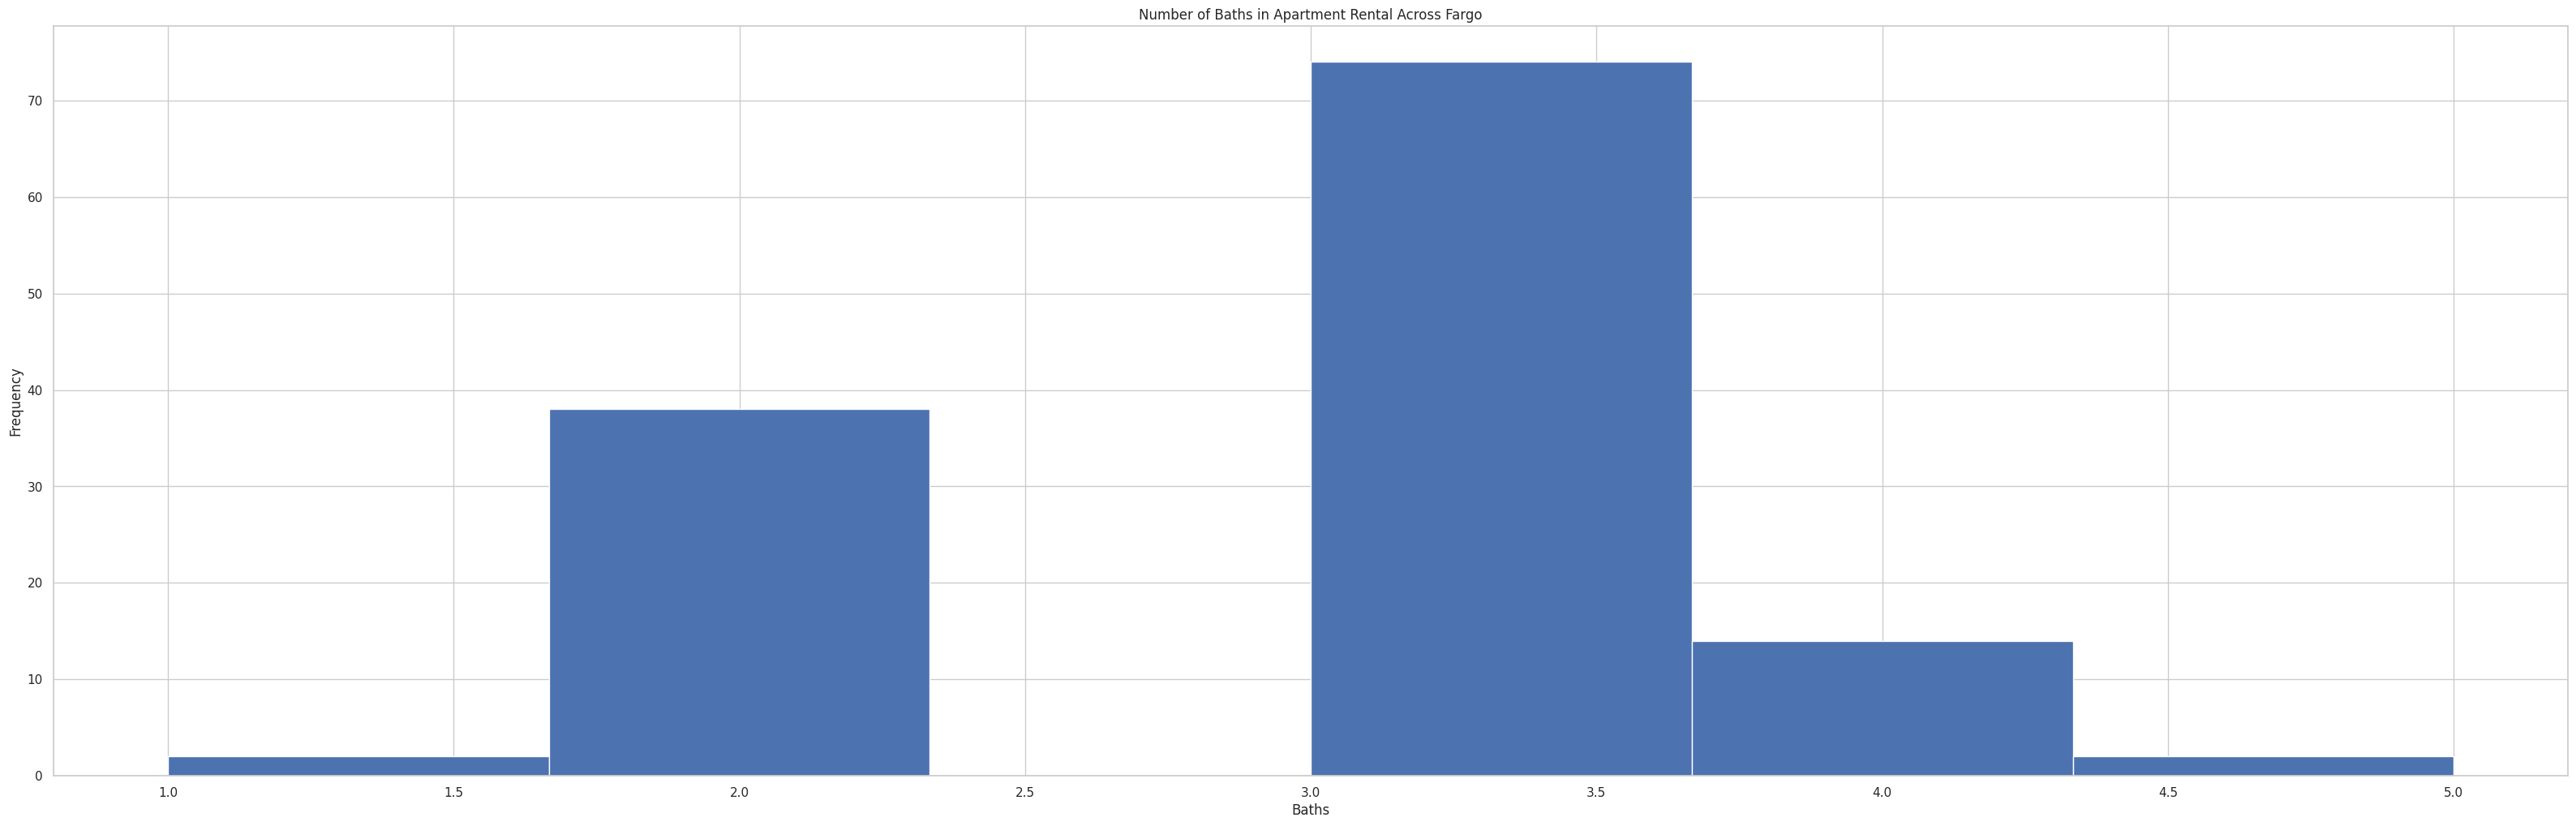

In [74]:
plt.hist(df['baths'], bins=6)
plt.xlabel('Baths')
plt.ylabel('Frequency')
plt.title('Number of Baths in Apartment Rental Across Fargo')
plt.show()

## Apartments

In [12]:
## averages of price and best deal

In [51]:
apt_averages = df2.copy()

# Step 1: Select columns of number apt_averages type
num_cols = apt_averages.select_dtypes(include=['int', 'float']).drop(['addressZipcode'], axis=1)

# Step 2: Calculate mean of each column
mean_row = num_cols.mean()

# Step 3: Append new row to apt_averagesframe
apt_averages = apt_averages.append(mean_row, ignore_index=True)

apt_averages = apt_averages.round(decimals = 2)

apt_averages = apt_averages[['unformattedPrice', 'zestimate', 'best_deal', 'beds', 'baths', 'area']]

print('Average Apartment: ')
apt_averages.tail(1)

Average Apartment: 


,unformattedPrice,zestimate,best_deal,beds,baths,area
69,875.11,15792.23,14917.13,1.89,1.27,1087.62


In [14]:
## Histogram of price

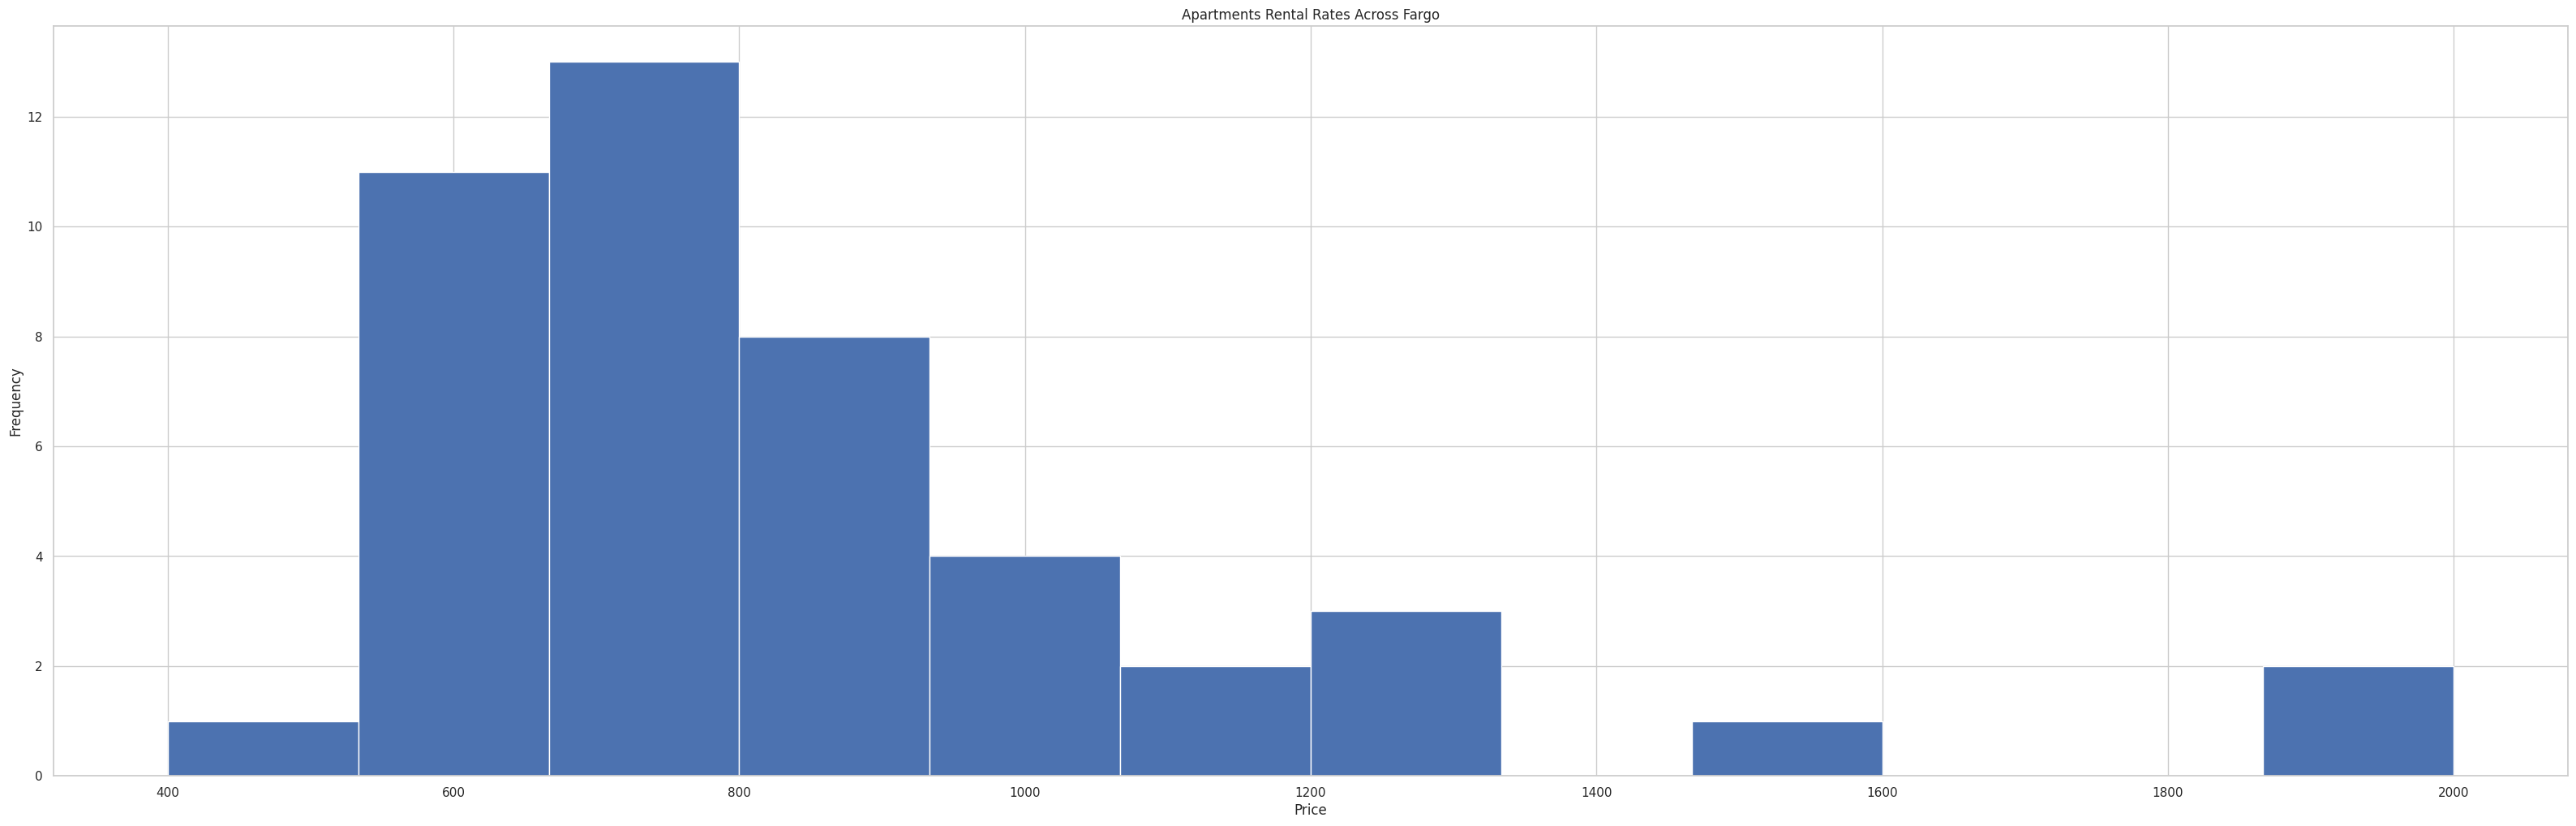

In [54]:
plt.hist(df2['unformattedPrice'], bins=12, range=(400, 2000))
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Apartments Rental Rates Across Fargo')
plt.show()

In [16]:
## beds, baths, and area

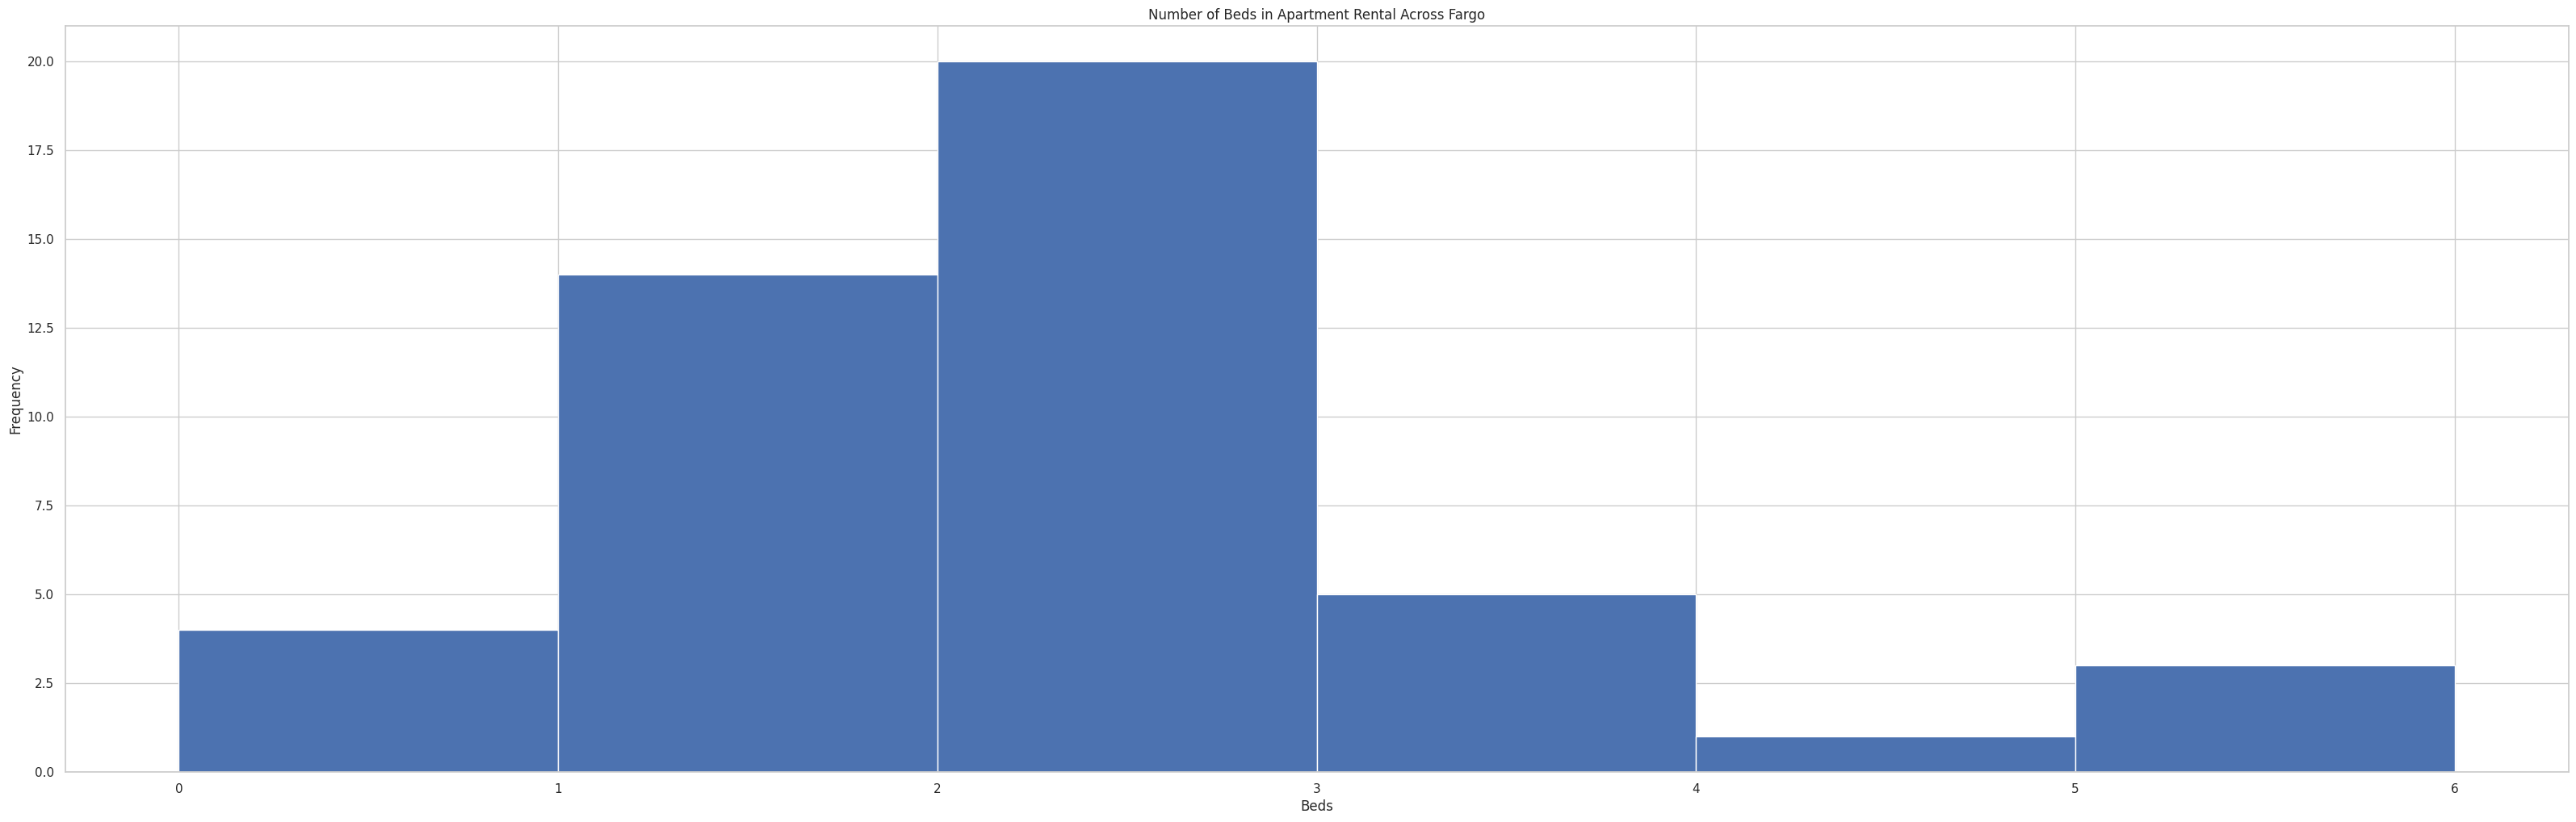

In [60]:
plt.hist(df2['beds'], bins=6)
plt.xlabel('Beds')
plt.ylabel('Frequency')
plt.title('Number of Beds in Apartment Rental Across Fargo')
plt.show()

In [67]:
plt.hist(df2['baths'], bins=4)
plt.xlabel('Baths')
plt.ylabel('Frequency')
plt.title('Number of Baths in Apartment Rental Across Fargo')
plt.show()

139    2.0
130    1.0
129    1.0
136    1.0
131    1.0
137    2.0
126    3.0
127    NaN
128    NaN
132    NaN
133    NaN
134    NaN
135    NaN
138    NaN
Name: baths, dtype: float64

In [17]:
## Pie chart of builders

In [79]:
import requests
import re
import json
import pandas as pd

import warnings

warnings.filterwarnings('ignore')

try:
    city = input("Enter the city name: ")
    state = input("Enter the state in abbreviation format (eg: Minnesota = MN) : ")

    while len(state) != 2:
        print("Invalid state entry. Try again.")
        state = input("Please try again: ")

    city = city.replace(" ", "-")
    city = city.capitalize()
    city_state = city + "-" + state

    # just grabbing the first 20 pages
    # feel free to make this prettier
    url1 = 'https://www.zillow.com/homes/for_sale/' + city + '/'
    url2 = 'https://www.zillow.com/homes/for_sale/' + city + '/2_p/'
    url3 = 'https://www.zillow.com/homes/for_sale/' + city + '/3_p/'
    url4 = 'https://www.zillow.com/homes/for_sale/' + city + '/4_p/'
    url5 = 'https://www.zillow.com/homes/for_sale/' + city + '/5_p/'
    url6 = 'https://www.zillow.com/homes/for_sale/' + city + '/6_p/'
    url7 = 'https://www.zillow.com/homes/for_sale/' + city + '/7_p/'
    url8 = 'https://www.zillow.com/homes/for_sale/' + city + '/8_p/'
    url9 = 'https://www.zillow.com/homes/for_sale/' + city + '/9_p/'
    url10 = 'https://www.zillow.com/homes/for_sale/' + city + '/10_p/'

    url11 = 'https://www.zillow.com/'+city_state+'/apartments/'
    url12 = 'https://www.zillow.com/'+city_state+'/apartments/2_p/'
    url13 = 'https://www.zillow.com/'+city_state+'/apartments/3_p/'
    url14 = 'https://www.zillow.com/'+city_state+'/apartments/4_p/'
    url15 = 'https://www.zillow.com/'+city_state+'/apartments/5_p/'
    url16 = 'https://www.zillow.com/'+city_state+'/apartments/6_p/'
    url17 = 'https://www.zillow.com/'+city_state+'/apartments/7_p/'
    url18 = 'https://www.zillow.com/'+city_state+'/apartments/8_p/'
    url19 = 'https://www.zillow.com/'+city_state+'/apartments/9_p/'
    url20 = 'https://www.zillow.com/'+city_state+'/apartments/10_p/'

    print("Scraping data...")

    # add headers in case you use chromedriver (captchas are no fun); namely used for chromedriver
    req_headers = {
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'en-US,en;q=0.8',
        'upgrade-insecure-requests': '1',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
    }

    with requests.Session() as s:
        r1 = s.get(url1, headers=req_headers)
        r2 = s.get(url2, headers=req_headers)
        r3 = s.get(url3, headers=req_headers)
        r4 = s.get(url4, headers=req_headers)
        r5 = s.get(url5, headers=req_headers)
        r6 = s.get(url6, headers=req_headers)
        r7 = s.get(url7, headers=req_headers)
        r8 = s.get(url8, headers=req_headers)
        r9 = s.get(url9, headers=req_headers)
        r10 = s.get(url10, headers=req_headers)

        r11 = s.get(url11, headers=req_headers)
        r12 = s.get(url12, headers=req_headers)
        r13 = s.get(url13, headers=req_headers)
        r14 = s.get(url14, headers=req_headers)
        r15 = s.get(url15, headers=req_headers)
        r16 = s.get(url16, headers=req_headers)
        r17 = s.get(url17, headers=req_headers)
        r18 = s.get(url18, headers=req_headers)
        r19 = s.get(url19, headers=req_headers)
        r20 = s.get(url20, headers=req_headers)

        data1 = json.loads(re.search(r'!--(\{"queryState".*?)-->', r1.text).group(1))
        data2 = json.loads(re.search(r'!--(\{"queryState".*?)-->', r2.text).group(1))
        data3 = json.loads(re.search(r'!--(\{"queryState".*?)-->', r3.text).group(1))
        data4 = json.loads(re.search(r'!--(\{"queryState".*?)-->', r4.text).group(1))
        data5 = json.loads(re.search(r'!--(\{"queryState".*?)-->', r5.text).group(1))
        data6 = json.loads(re.search(r'!--(\{"queryState".*?)-->', r6.text).group(1))
        data7 = json.loads(re.search(r'!--(\{"queryState".*?)-->', r7.text).group(1))
        data8 = json.loads(re.search(r'!--(\{"queryState".*?)-->', r8.text).group(1))
        data9 = json.loads(re.search(r'!--(\{"queryState".*?)-->', r9.text).group(1))
        data10 = json.loads(re.search(r'!--(\{"queryState".*?)-->', r10.text).group(1))

        data11 = json.loads(re.search(r'!--(\{"queryState".*?)-->', r11.text).group(1))
        data12 = json.loads(re.search(r'!--(\{"queryState".*?)-->', r12.text).group(1))
        data13 = json.loads(re.search(r'!--(\{"queryState".*?)-->', r13.text).group(1))
        data14 = json.loads(re.search(r'!--(\{"queryState".*?)-->', r14.text).group(1))
        data15 = json.loads(re.search(r'!--(\{"queryState".*?)-->', r15.text).group(1))
        data16 = json.loads(re.search(r'!--(\{"queryState".*?)-->', r16.text).group(1))
        data17 = json.loads(re.search(r'!--(\{"queryState".*?)-->', r17.text).group(1))
        data18 = json.loads(re.search(r'!--(\{"queryState".*?)-->', r18.text).group(1))
        data19 = json.loads(re.search(r'!--(\{"queryState".*?)-->', r19.text).group(1))
        data20 = json.loads(re.search(r'!--(\{"queryState".*?)-->', r20.text).group(1))

    data_list = [data1, data2, data3, data4, data5, data6, data7, data8, data9, data10]
    data_list2 = [data11, data12, data13, data14, data15, data16, data17, data18, data19, data20]

    df = pd.DataFrame()
    df2 = pd.DataFrame()

    def make_frame(frame):
        for i in data_list:
            for item in i['cat1']['searchResults']['listResults']:
                frame = frame.append(item, ignore_index=True)
        return frame

    def make_frame2(frame2):
        for i in data_list2:
            for item in i['cat1']['searchResults']['listResults']:
                frame2 = frame2.append(item, ignore_index=True)
        return frame2



    df = make_frame(df)
    df2 = make_frame2(df2)

    # drop dupes
    df = df.drop_duplicates(subset='zpid', keep="last")
    df2 = df2.drop_duplicates(subset='zpid', keep="last")

    # filters
    df['zestimate'] = df['zestimate'].fillna(0)
    df['best_deal'] = df['unformattedPrice'] - df['zestimate']
    df = df.sort_values(by='best_deal', ascending=True)

    df2['zestimate'] = df2['zestimate'].fillna(0)
    df2['best_deal'] = df2['unformattedPrice'] - df2['zestimate']
    df2 = df2.sort_values(by='best_deal', ascending=True)

    data = df[['zpid', 'imgSrc', 'statusType', 'price', 'unformattedPrice', 'zestimate', 'best_deal', 'address', 'addressZipcode', 'beds', 'baths', 'area', 'variableData', 'brokerName', 'builderName']]
    #data.to_csv("./data/" + city + "_Homes_ForSale.csv")

    data2 = df2[['zpid', 'imgSrc', 'statusType', 'price', 'unformattedPrice', 'zestimate', 'best_deal', 'address', 'addressZipcode', 'beds', 'baths', 'area', 'variableData']]
    #data2.to_csv("./data/" + city + "_Apartments_ForRental.csv")
    
    #print('Done.\n'+city+"_Homes_ForSale.csv is available for viewing.\n"+city+"_Apartments_ForRental.csv is available for viewing.")

except:
    print("Error: The City or State entered could not be found.")
df2.to_csv("./data/" + city + "_Apartments_ForRental_ALL.csv")

Enter the city name:  fargo
Enter the state in abbreviation format (eg: Minnesota = MN) :  nd


Scraping data...
Error: The City or State entered could not be found.


In [18]:
## Pie chart of brokers

In [19]:
## Pie chart of open house